In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn, optim
import torch.nn.functional as F

# LeNet-5 Architecture

- 1st Layer (Conv) --> 6 5x5 Filters w/ Stride 1
- Pooling Layer --> Average (original) or Max (modern) 2x2 w/ stride 2

- 2nd Layer (Conv) --> 16 5x5 Filters w/ Stride 1
- Pooling Layer --> Average (original) or Max (modern) 2x2 w/ stride 2

- 3rd Layer (Fully-Connected) --> 120

- 4th Layer (FC) --> 84

- 5th Layer (Output) --> Depends

In [33]:
class LeNet_Model(nn.Module):
    
    def __init__(self, in_channels, fc1_dim, classes):
        super(LeNet_Model, self).__init__()
        
        # Define Conv Layers
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        
        # Define Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully-Connected Layers
        self.fc1 = nn.Linear(fc1_dim, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, classes)
        
        self.fc1_dim = fc1_dim
        
    def forward(self, x):
        # LeNet Sequence
        # 1st layer
        output = F.relu(self.conv1(x))
        output = self.pool(output)
        
        # 2nd layer
        output = F.relu(self.conv2(output))
        output = self.pool(output)
        
        # Flatten
        output = output.view(-1, self.fc1_dim)
        
        # 3rd & 4th layers
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        
        # output layer
        output = F.softmax(self.fc3(output), dim=1)
        
        return output

In [34]:
cuda = torch.cuda.is_available()

# Import data to test

In [13]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from torchsummary import summary

## MNIST

In [9]:
# Data Augmentation & Transformation
transform = transforms.Compose([
    transforms.ToTensor() # tranform matrix to tensor
])

# Download & load in-memory
trainset = datasets.MNIST(root='../data', download=True, train=True, transform=transform)

In [16]:
# Train valid split
valid_size = 0.2 # validation size

num_train = len(trainset) # number of examples
idx = list(range(num_train)) # indices
np.random.shuffle(idx)
split = int(np.floor(valid_size*num_train)) # index to split
train_idx, valid_idx = idx[split:], idx[:split]

# Samples randomly from a given list of indices
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Create DataLoader for train & valid set - iterable
batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
validloader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)

In [17]:
# Test set
# Load data
testset = datasets.MNIST(root='../data', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True) # Dataloader

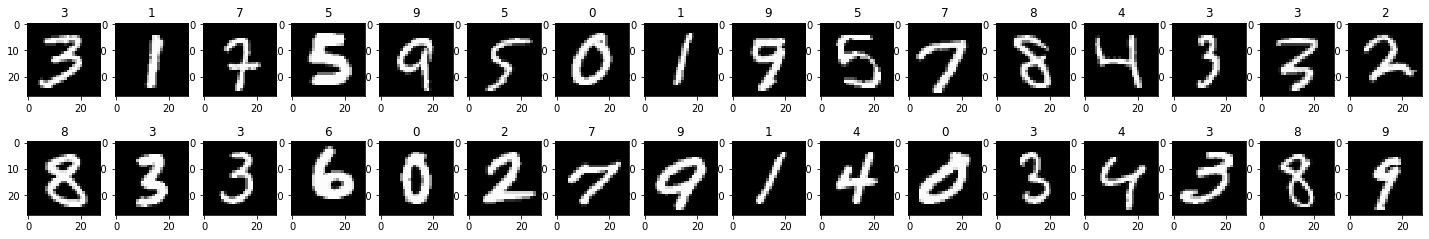

In [20]:
images, labels = next(iter(trainloader))
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for i in range(32):
    ax = fig.add_subplot(2, 32/2, i+1)
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(str(labels[i].item()))

In [26]:
images.shape

(32, 1, 28, 28)

## Initialise Model

Calculate image size for layers
- Input Image - 28x28
- 1st Layer --> 5x5 filters w/ stride 1 --> 24 x 24
- Pooling Layer --> 2x2 w/ stride 2 --> 12 x 12

- 2nd Layer --> 5x5 filters w/ stride 1 --> 8x8
- Pooling Layer --> 4x4

- Fc1 --> 16x4x4 = 256

In [44]:
# Model
lenet_model = LeNet_Model(in_channels=1, fc1_dim=256, classes=10)
if cuda:
    lenet_model.cuda()

# Cost Function & Optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(lenet_model.parameters(), lr=0.001)

In [45]:
# training
epochs = 20
train_loss = []
valid_loss = []

for e in range(epochs):
    running_train_loss = 0
    running_valid_loss = 0
    
    # loop through training set
    for images, labels in trainloader:
        if cuda:
            images, labels = images.cuda(), labels.cuda()
            
        optimiser.zero_grad() # zero out gradients
        
        output = lenet_model.forward(images) # forward prop
        loss = criterion(output, labels) # calculate cost
        running_train_loss += loss.item()*images.size(0) # update train loss
        
        loss.backward() # backprop
        optimiser.step() # update weights
    
    # loop through validation set to calculate loss
    for images, labels in validloader:
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        output = lenet_model.forward(images)
        loss = criterion(output, labels)
        running_valid_loss += loss.item()*images.size(0) # update val loss
        
    # Compute loss
    running_train_loss = running_train_loss/len(trainloader)
    running_valid_loss = running_valid_loss/len(validloader)
    
    # Save loss
    train_loss.append(running_train_loss)
    valid_loss.append(running_valid_loss)
    
    print('Epochs {}/{}: --- Training Loss: {} --- Validation Loss: {}'.format(e+1, epochs, running_train_loss, running_valid_loss))

Epochs 1/20: --- Training Loss: 53.61650493367513 --- Validation Loss: 50.86252314249675
Epochs 2/20: --- Training Loss: 48.15793966420492 --- Validation Loss: 48.044574747721356
Epochs 3/20: --- Training Loss: 47.70778106180827 --- Validation Loss: 47.49131172688802
Epochs 4/20: --- Training Loss: 47.57440171305338 --- Validation Loss: 47.537476755777995
Epochs 5/20: --- Training Loss: 47.46573441823323 --- Validation Loss: 47.43526824951172
Epochs 6/20: --- Training Loss: 47.39398864746094 --- Validation Loss: 47.37755458577474
Epochs 7/20: --- Training Loss: 47.322580861409506 --- Validation Loss: 47.61165219116211
Epochs 8/20: --- Training Loss: 47.32068255106608 --- Validation Loss: 47.465095489501955
Epochs 9/20: --- Training Loss: 47.275518267313636 --- Validation Loss: 47.30274522908529
Epochs 10/20: --- Training Loss: 47.27098138173421 --- Validation Loss: 47.38172862752278
Epochs 11/20: --- Training Loss: 47.23667022705078 --- Validation Loss: 47.31666748046875
Epochs 12/20: 

## Loss curve

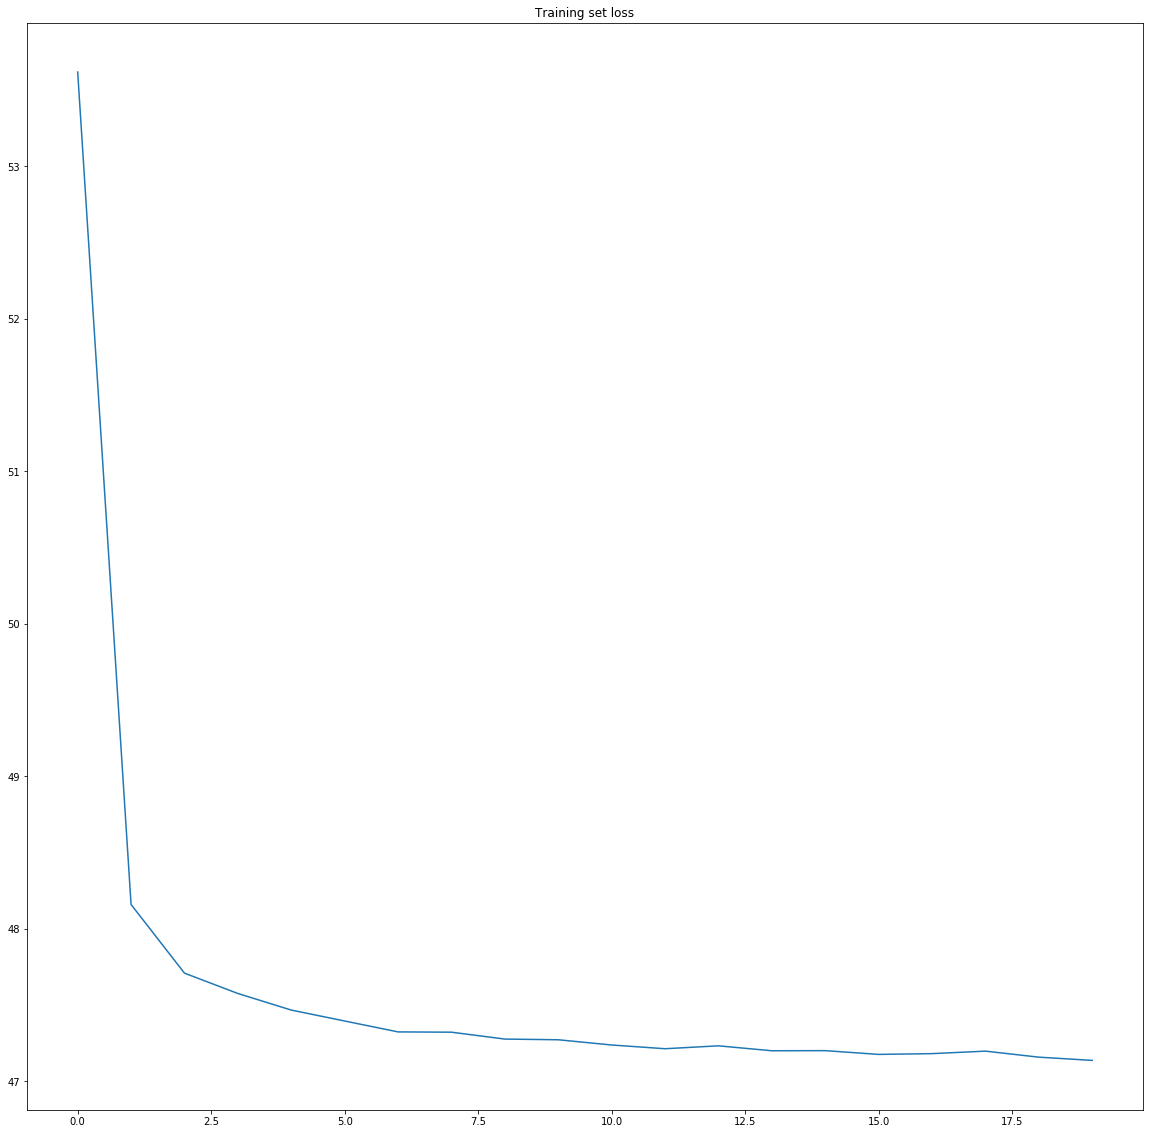

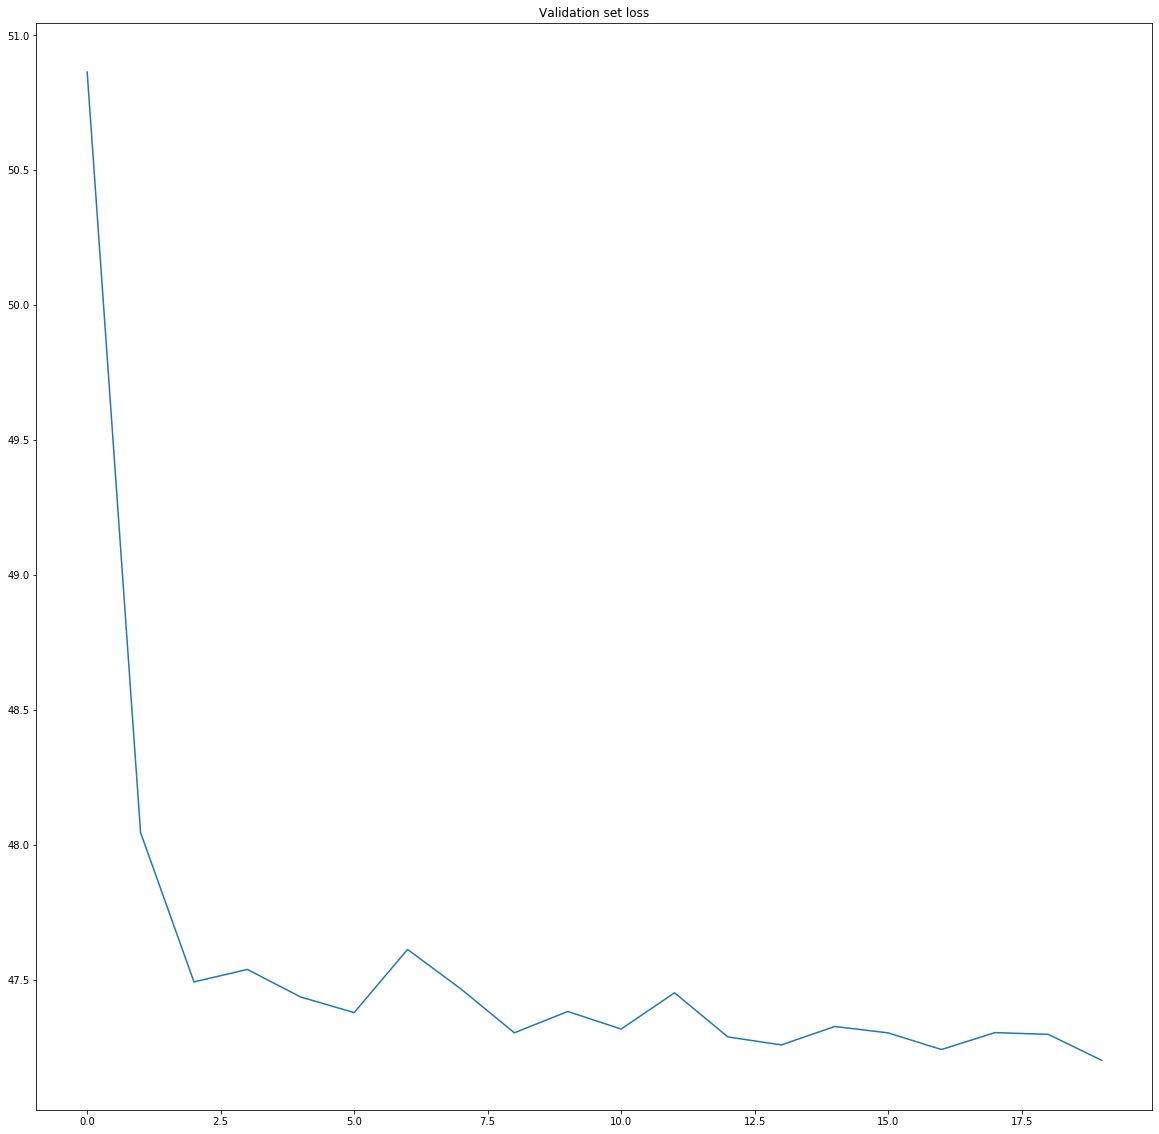

In [46]:
plt.figure(figsize=(20,20))
plt.plot(range(len(train_loss)), train_loss)
plt.title('Training set loss')
plt.show()

plt.figure(figsize=(20,20))
plt.plot(range(len(valid_loss)), valid_loss)
plt.title('Validation set loss')
plt.show()

## Test Set

In [48]:
# Testing
test_loss = 0.0
# 10 classes
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

lenet_model.eval() # switch model to evaluation mode

for images, labels in testloader:
    if cuda:
        images, labels = images.cuda(), labels.cuda()
        
    output = lenet_model(images) # compute predictions
    loss = criterion(output, labels) # compute loss
    test_loss += loss.item() # update test loss
        
    _, pred = torch.max(output, 1) # Convert highest probability as the prediction
    correct = np.squeeze(pred.eq(labels.data.view_as(pred))) # compare y-hat with y
    
    # calculate test accuracy
    for i in range(images.shape[0]):
        label = labels.data[i] # y of the image
        class_correct[label] += correct[i].item() # add count to class score
        class_total[label] += 1 # add to total number of examples of class

In [54]:
# Loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# Accuracy
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of {}: {:.2f} ({:.0f}/{:.0f})'.format(i, 
                                                                 100*class_correct[i]/class_total[i], 
                                                                 np.sum(class_correct[i]),
                                                                 np.sum(class_total[i])
                                                                ))
print()
print('Overall Accuracy: {:.2f} ({:.0f}/{:.0f})'.format(100*np.sum(class_correct) / np.sum(class_total),
                                                        np.sum(class_correct),
                                                        np.sum(class_total)
                                                       ))

Test Accuracy of 0: 99.08 (971/980)
Test Accuracy of 1: 99.21 (1126/1135)
Test Accuracy of 2: 99.13 (1023/1032)
Test Accuracy of 3: 98.51 (995/1010)
Test Accuracy of 4: 98.57 (968/982)
Test Accuracy of 5: 97.87 (873/892)
Test Accuracy of 6: 99.16 (950/958)
Test Accuracy of 7: 99.12 (1019/1028)
Test Accuracy of 8: 98.46 (959/974)
Test Accuracy of 9: 98.51 (994/1009)

Overall Accuracy: 98.78 (9878/10000)


## CIFAR

In [55]:
# Training data
trainset = datasets.CIFAR10(root='../data', download=True, train=True, transform=transform)

Files already downloaded and verified


In [57]:
# Train valid split
valid_size = 0.2 # validation size

num_train = len(trainset) # number of examples
idx = list(range(num_train)) # indices
np.random.shuffle(idx)
split = int(np.floor(valid_size*num_train)) # index to split
train_idx, valid_idx = idx[split:], idx[:split]

# Samples randomly from a given list of indices
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Create DataLoader for train & valid set - iterable
batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
validloader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)

In [58]:
# Test set
# Load data
testset = datasets.CIFAR10(root='../data', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True) # Dataloader

Files already downloaded and verified


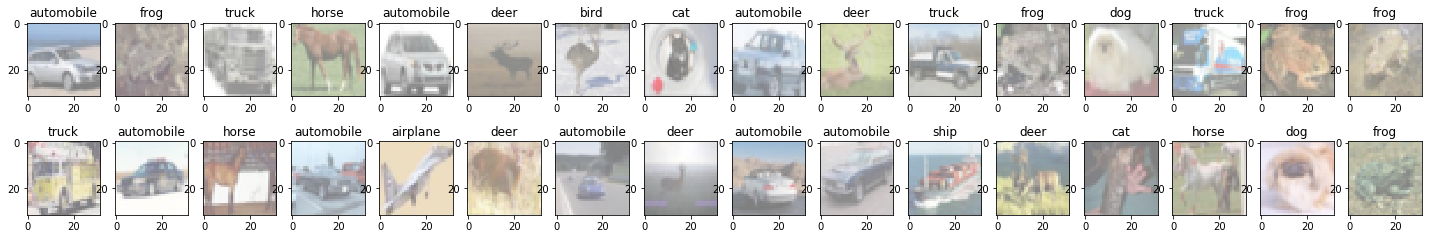

In [60]:
images, labels = next(iter(trainloader))
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for i in range(32):
    ax = fig.add_subplot(2, 32/2, i+1)
    ax.imshow(np.transpose(images[i]/2 + 0.5, (1,2,0))) # Unnormalise before plotting
    ax.set_title(classes[labels[i]])

In [59]:
# classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [61]:
images.shape

(32, 3, 32, 32)

## Initialise Model

Calculate image size for layers
- Input Image - 32x32
- 1st Layer --> 5x5 filters w/ stride 1 --> 28x28
- Pooling Layer --> 2x2 w/ stride 2 --> 14x14

- 2nd Layer --> 5x5 filters w/ stride 1 --> 10x10
- Pooling Layer --> 5x5

- Fc1 --> 16x5x5 = 400

In [70]:
# Model
lenet_model = LeNet_Model(in_channels=3, fc1_dim=400, classes=10)
if cuda:
    lenet_model.cuda()

# Cost Function & Optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(lenet_model.parameters(), lr=0.001)

In [71]:
# training
epochs = 100
train_loss = []
valid_loss = []

for e in range(epochs):
    running_train_loss = 0
    running_valid_loss = 0
    
    # loop through training set
    for images, labels in trainloader:
        if cuda:
            images, labels = images.cuda(), labels.cuda()
            
        optimiser.zero_grad() # zero out gradients
        
        output = lenet_model.forward(images) # forward prop
        loss = criterion(output, labels) # calculate cost
        running_train_loss += loss.item()*images.size(0) # update train loss
        
        loss.backward() # backprop
        optimiser.step() # update weights
    
    # loop through validation set to calculate loss
    for images, labels in validloader:
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        output = lenet_model.forward(images)
        loss = criterion(output, labels)
        running_valid_loss += loss.item()*images.size(0) # update val loss
        
    # Compute loss
    running_train_loss = running_train_loss/len(trainloader)
    running_valid_loss = running_valid_loss/len(validloader)
    
    # Save loss
    train_loss.append(running_train_loss)
    valid_loss.append(running_valid_loss)
    
    print('Epochs {}/{}: --- Training Loss: {} --- Validation Loss: {}'.format(e+1, epochs, running_train_loss, running_valid_loss))

Epochs 1/100: --- Training Loss: 69.30412471313477 --- Validation Loss: 67.39667662111715
Epochs 2/100: --- Training Loss: 66.86458290405274 --- Validation Loss: 65.96428235575033
Epochs 3/100: --- Training Loss: 65.42725416870117 --- Validation Loss: 64.31740271473845
Epochs 4/100: --- Training Loss: 64.69754261169433 --- Validation Loss: 64.14951932620697
Epochs 5/100: --- Training Loss: 64.14101258850097 --- Validation Loss: 63.731502063739036
Epochs 6/100: --- Training Loss: 63.543919110107424 --- Validation Loss: 63.26990622377243
Epochs 7/100: --- Training Loss: 63.177315249633786 --- Validation Loss: 62.85972754871502
Epochs 8/100: --- Training Loss: 62.7363651550293 --- Validation Loss: 62.98864370717789
Epochs 9/100: --- Training Loss: 62.26495628356933 --- Validation Loss: 62.61443066825501
Epochs 10/100: --- Training Loss: 62.10298189697266 --- Validation Loss: 62.33622713667897
Epochs 11/100: --- Training Loss: 61.838934210205075 --- Validation Loss: 62.691417377215984
Epoc

Epochs 91/100: --- Training Loss: 61.749849188232425 --- Validation Loss: 64.48777017806665
Epochs 92/100: --- Training Loss: 61.6074212310791 --- Validation Loss: 62.12583324932062
Epochs 93/100: --- Training Loss: 61.3455511505127 --- Validation Loss: 63.033897095214066
Epochs 94/100: --- Training Loss: 61.24500479125977 --- Validation Loss: 62.54417570558981
Epochs 95/100: --- Training Loss: 61.1982525390625 --- Validation Loss: 63.55338629823142
Epochs 96/100: --- Training Loss: 61.58513736877441 --- Validation Loss: 62.30711036901504
Epochs 97/100: --- Training Loss: 61.36689974365235 --- Validation Loss: 63.167061583302655
Epochs 98/100: --- Training Loss: 61.40261390991211 --- Validation Loss: 64.47963428192627
Epochs 99/100: --- Training Loss: 61.92878997192383 --- Validation Loss: 63.552323838011525
Epochs 100/100: --- Training Loss: 61.70916823425293 --- Validation Loss: 62.220256354481265


## Loss Curve

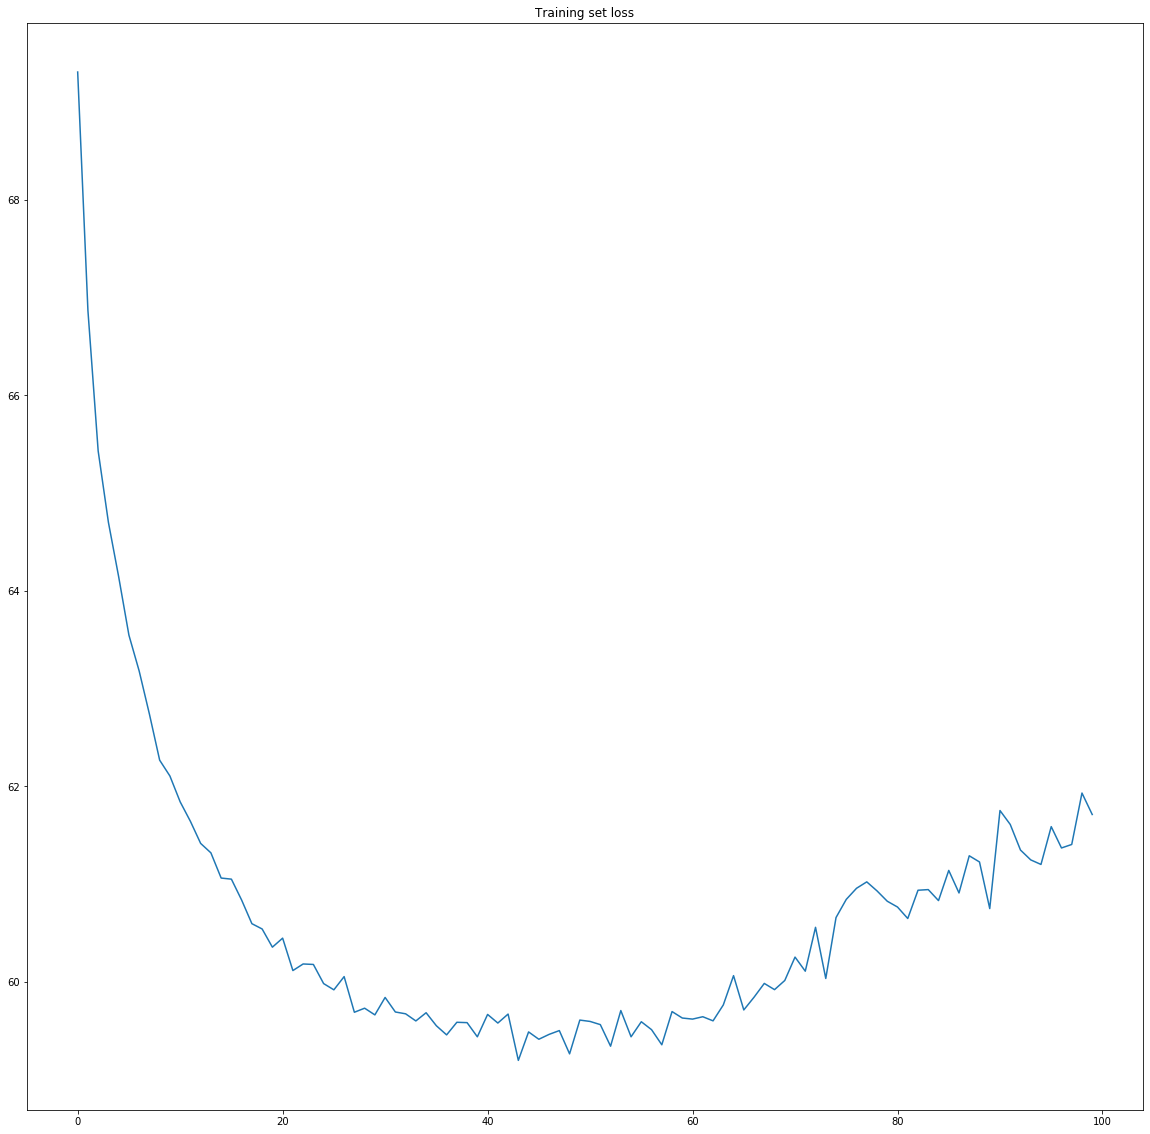

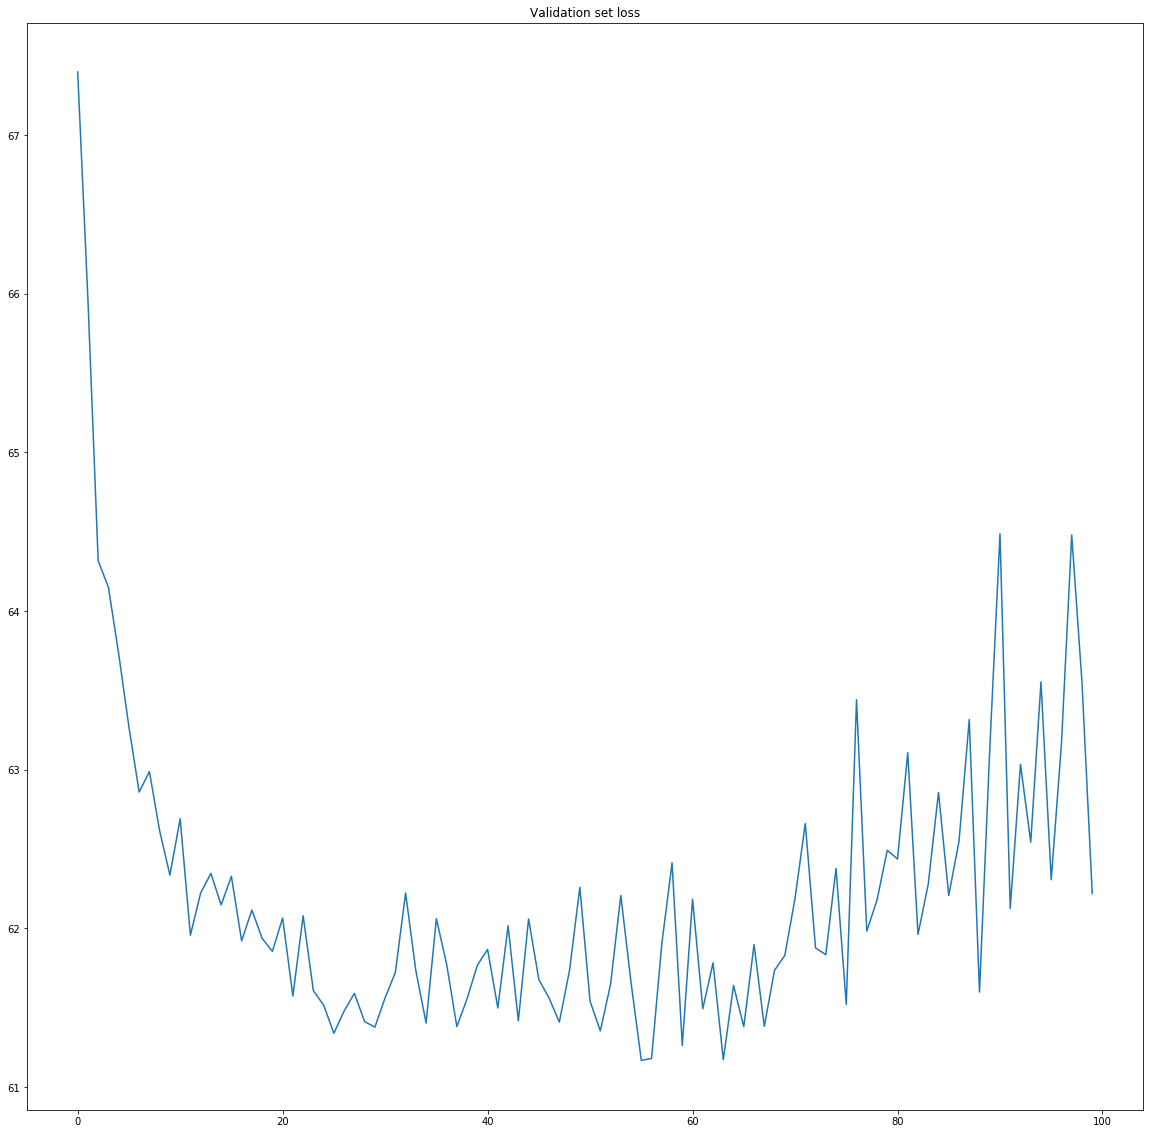

In [72]:
plt.figure(figsize=(20,20))
plt.plot(range(len(train_loss)), train_loss)
plt.title('Training set loss')
plt.show()

plt.figure(figsize=(20,20))
plt.plot(range(len(valid_loss)), valid_loss)
plt.title('Validation set loss')
plt.show()

## Test Set

In [73]:
# Testing
test_loss = 0.0
# 10 classes
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

lenet_model.eval() # switch model to evaluation mode

for images, labels in testloader:
    if cuda:
        images, labels = images.cuda(), labels.cuda()
        
    output = lenet_model(images) # compute predictions
    loss = criterion(output, labels) # compute loss
    test_loss += loss.item() # update test loss
        
    _, pred = torch.max(output, 1) # Convert highest probability as the prediction
    correct = np.squeeze(pred.eq(labels.data.view_as(pred))) # compare y-hat with y
    
    # calculate test accuracy
    for i in range(images.shape[0]):
        label = labels.data[i] # y of the image
        class_correct[label] += correct[i].item() # add count to class score
        class_total[label] += 1 # add to total number of examples of class

In [74]:
# Loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# Accuracy
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of {}: {:.2f} ({:.0f}/{:.0f})'.format(i, 
                                                                 100*class_correct[i]/class_total[i], 
                                                                 np.sum(class_correct[i]),
                                                                 np.sum(class_total[i])
                                                                ))
print()
print('Overall Accuracy: {:.2f} ({:.0f}/{:.0f})'.format(100*np.sum(class_correct) / np.sum(class_total),
                                                        np.sum(class_correct),
                                                        np.sum(class_total)
                                                       ))

Test Loss: 0.061126

Test Accuracy of 0: 63.80 (638/1000)
Test Accuracy of 1: 53.60 (536/1000)
Test Accuracy of 2: 25.50 (255/1000)
Test Accuracy of 3: 47.80 (478/1000)
Test Accuracy of 4: 42.40 (424/1000)
Test Accuracy of 5: 44.00 (440/1000)
Test Accuracy of 6: 62.40 (624/1000)
Test Accuracy of 7: 54.10 (541/1000)
Test Accuracy of 8: 72.40 (724/1000)
Test Accuracy of 9: 41.90 (419/1000)

Overall Accuracy: 50.79 (5079/10000)
